# DB EDA Analisys

# 전체 플로우

In [1]:

'''
Step 1.
XGBoost 모델 예측
        ↓
trading_signals 테이블에 저장
  ↳ strategy_name = "XGBOOST_PREDICTOR"
  ↳ signal_source = "AI_MODEL" 
  ↳ signal_type = "LONG/SHORT/HOLD"
  ↳ prediction_probability = 0.7234
  ↳ features_data = JSON (RSI, MACD 등)

Step 2.
PyQt5 GUI (strategy_widget.py)
        ↓
trading_signals 테이블 조회
  ↳ WHERE signal_source = 'AI_MODEL'
  ↳ WHERE processed = FALSE
  ↳ ORDER BY created_at DESC
        ↓
새로운 AI 시그널 발견 시
        ↓
자동매매 실행 (binance_client.py)
        ↓
processed = TRUE로 업데이트
'''

'\nStep 1.\nXGBoost 모델 예측\n        ↓\ntrading_signals 테이블에 저장\n  ↳ strategy_name = "XGBOOST_PREDICTOR"\n  ↳ signal_source = "AI_MODEL" \n  ↳ signal_type = "LONG/SHORT/HOLD"\n  ↳ prediction_probability = 0.7234\n  ↳ features_data = JSON (RSI, MACD 등)\n\nStep 2.\nPyQt5 GUI (strategy_widget.py)\n        ↓\ntrading_signals 테이블 조회\n  ↳ WHERE signal_source = \'AI_MODEL\'\n  ↳ WHERE processed = FALSE\n  ↳ ORDER BY created_at DESC\n        ↓\n새로운 AI 시그널 발견 시\n        ↓\n자동매매 실행 (binance_client.py)\n        ↓\nprocessed = TRUE로 업데이트\n'

# 1. DB 구조설명

In [3]:
import pandas as pd
import mysql.connector

DB_CONFIG = {
    'host': 'localhost',
    'port': 3306,
    'user': 'root',
    'password': 'ghkd2759A!',
    'database': 'trading_signals'
}

connection = mysql.connector.connect(**DB_CONFIG)

print("🏗️ 데이터베이스 구조 설명")
print("=" * 50)

# 1. 메인 테이블 - trading_signals
print("1️⃣ trading_signals (메인 테이블)")
print("   역할: 모든 거래 시그널을 저장하는 핵심 테이블")
signals_df = pd.read_sql("SELECT id, strategy_name, symbol, signal_type, created_at FROM trading_signals", connection)
print(f"   레코드: {len(signals_df)}개")
print(signals_df.head(3))

print("\n" + "-" * 50)

# 2. 전략 설정 테이블
print("2️⃣ strategy_configs (전략 설정 테이블)")  
print("   역할: 사용 가능한 거래 전략들을 관리")
strategies_df = pd.read_sql("SELECT strategy_name, strategy_type, is_active FROM strategy_configs", connection)
print(f"   레코드: {len(strategies_df)}개")
print(strategies_df)

print("\n" + "-" * 50)

# 3. 지원 심볼 테이블
print("3️⃣ supported_symbols (심볼 테이블)")
print("   역할: 거래 가능한 암호화폐 목록 관리")
symbols_df = pd.read_sql("SELECT symbol, base_asset, quote_asset FROM supported_symbols LIMIT 5", connection)
print(f"   레코드: {len(symbols_df)}개 (처음 5개만 표시)")
print(symbols_df)

print("\n" + "-" * 50)

# 4. 관계 설명
print("🔗 테이블 간 관계:")
print("""
trading_signals.strategy_name → strategy_configs.strategy_name
trading_signals.symbol → supported_symbols.symbol

즉, 시그널이 저장될 때:
- strategy_name은 strategy_configs에 등록된 전략이어야 함
- symbol은 supported_symbols에 등록된 심볼이어야 함
""")

# 5. 실제 조인 예시
print("🔍 실제 조인 쿼리 예시:")
join_query = """
SELECT 
    ts.id,
    ts.strategy_name,
    sc.strategy_type,
    ts.symbol,
    ss.base_asset,
    ts.signal_type,
    ts.created_at
FROM trading_signals ts
LEFT JOIN strategy_configs sc ON ts.strategy_name = sc.strategy_name  
LEFT JOIN supported_symbols ss ON ts.symbol = ss.symbol
ORDER BY ts.created_at DESC
LIMIT 5
"""

result_df = pd.read_sql(join_query, connection)
print(result_df)

connection.close()

print(f"\n💡 요약:")
print("- 1개 데이터베이스 안에 4개 테이블")
print("- trading_signals가 메인, 나머지는 설정/관리용")
print("- 새로운 전략/심볼을 자유롭게 추가 가능")

🏗️ 데이터베이스 구조 설명
1️⃣ trading_signals (메인 테이블)
   역할: 모든 거래 시그널을 저장하는 핵심 테이블
   레코드: 5개
   id      strategy_name   symbol signal_type          created_at
0   1       RSI_REVERSAL  BTCUSDT        LONG 2025-09-24 17:55:38
1   2  XGBOOST_PREDICTOR  ETHUSDT       SHORT 2025-09-24 17:55:38
2   3       RSI_REVERSAL  BTCUSDT        LONG 2025-09-24 18:08:21

--------------------------------------------------
2️⃣ strategy_configs (전략 설정 테이블)
   역할: 사용 가능한 거래 전략들을 관리
   레코드: 4개
        strategy_name strategy_type  is_active
0        RSI_REVERSAL     TECHNICAL          1
1       MACD_MOMENTUM     TECHNICAL          1
2   XGBOOST_PREDICTOR      AI_MODEL          1
3  BOLLINGER_BREAKOUT     TECHNICAL          1

--------------------------------------------------
3️⃣ supported_symbols (심볼 테이블)
   역할: 거래 가능한 암호화폐 목록 관리
   레코드: 5개 (처음 5개만 표시)
     symbol base_asset quote_asset
0   BTCUSDT        BTC        USDT
1   ETHUSDT        ETH        USDT
2   ADAUSDT        ADA        USDT
3   DOTUSDT        DOT 

C:\Users\soekjun\AppData\Local\Temp\ipykernel_18496\1560470497.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  signals_df = pd.read_sql("SELECT id, strategy_name, symbol, signal_type, created_at FROM trading_signals", connection)
C:\Users\soekjun\AppData\Local\Temp\ipykernel_18496\1560470497.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  strategies_df = pd.read_sql("SELECT strategy_name, strategy_type, is_active FROM strategy_configs", connection)
C:\Users\soekjun\AppData\Local\Temp\ipykernel_18496\1560470497.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects ar

# DB table -> 데이터프레임 가시화

In [4]:
import pandas as pd
import mysql.connector

# DB 연결 설정
DB_CONFIG = {
    'host': 'localhost',
    'port': 3306,
    'user': 'root',
    'password': 'ghkd2759A!',
    'database': 'trading_signals'
}

# 연결
connection = mysql.connector.connect(**DB_CONFIG)

# 각 테이블을 DataFrame으로 가져오기
signals_df = pd.read_sql("SELECT * FROM trading_signals", connection)
strategies_df = pd.read_sql("SELECT * FROM strategy_configs", connection)
symbols_df = pd.read_sql("SELECT * FROM supported_symbols", connection)
ai_models_df = pd.read_sql("SELECT * FROM ai_models", connection)

# 결과 출력
print("📊 Trading Signals:")
display(signals_df)

print("\n⚙️ Strategies:")
display(strategies_df)

print("\n💰 Symbols:")
display(symbols_df)


print("\n💰 AI Models:")
display(ai_models_df)

connection.close()

📊 Trading Signals:


C:\Users\soekjun\AppData\Local\Temp\ipykernel_18496\4222956079.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  signals_df = pd.read_sql("SELECT * FROM trading_signals", connection)
C:\Users\soekjun\AppData\Local\Temp\ipykernel_18496\4222956079.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  strategies_df = pd.read_sql("SELECT * FROM strategy_configs", connection)
C:\Users\soekjun\AppData\Local\Temp\ipykernel_18496\4222956079.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  symbols_df = pd.read_sql("SELECT * FR

,id,strategy_name,symbol,timeframe,signal_type,signal_source,price,volume,confidence,prediction_probability,features_data,model_version,message,webhook_data,created_at,processed,processed_at
0,1,RSI_REVERSAL,BTCUSDT,1h,LONG,TRADINGVIEW,45000.50,None,0.85,None,None,None,RSI 과매도 반등 시그널,None,2025-09-24 17:55:38,0,None
1,2,XGBOOST_PREDICTOR,ETHUSDT,1d,SHORT,AI_MODEL,2800.75,None,0.72,None,None,None,AI 모델 하락 예측,None,2025-09-24 17:55:38,0,None
2,3,RSI_REVERSAL,BTCUSDT,1h,LONG,TRADINGVIEW,45000.50,None,0.85,None,None,None,테스트 롱 시그널,None,2025-09-24 18:08:21,0,None
3,4,XGBOOST_PREDICTOR,ETHUSDT,1d,SHORT,AI_MODEL,2800.75,None,0.72,None,None,None,AI 숏 예측,None,2025-09-24 18:08:21,0,None
4,5,MACD_MOMENTUM,ADAUSDT,4h,HOLD,TRADINGVIEW,1.25,None,0.45,None,None,None,관망 신호,None,2025-09-24 18:08:21,0,None



⚙️ Strategies:


,id,strategy_name,strategy_type,description,parameters,is_active,created_at,updated_at
0,1,RSI_REVERSAL,TECHNICAL,RSI 역추세 전략,"{""oversold"": 30, ""overbought"": 70, ""rsi_period...",1,2025-09-24 17:55:38,2025-09-24 17:55:38
1,2,MACD_MOMENTUM,TECHNICAL,MACD 모멘텀 전략,"{""fast"": 12, ""slow"": 26, ""signal"": 9}",1,2025-09-24 17:55:38,2025-09-24 17:55:38
2,3,XGBOOST_PREDICTOR,AI_MODEL,XGBoost 가격 예측 모델,"{""lookback_period"": 20, ""prediction_horizon"": 1}",1,2025-09-24 17:55:38,2025-09-24 17:55:38
3,4,BOLLINGER_BREAKOUT,TECHNICAL,볼린저 밴드 브레이크아웃,"{""period"": 20, ""std_dev"": 2}",1,2025-09-24 17:55:38,2025-09-24 17:55:38



💰 Symbols:


,id,symbol,base_asset,quote_asset,exchange,is_active,min_notional,price_precision,qty_precision,created_at
0,1,BTCUSDT,BTC,USDT,BINANCE,1,None,8,6,2025-09-24 17:55:38
1,2,ETHUSDT,ETH,USDT,BINANCE,1,None,8,6,2025-09-24 17:55:38
2,3,ADAUSDT,ADA,USDT,BINANCE,1,None,8,6,2025-09-24 17:55:38
3,4,DOTUSDT,DOT,USDT,BINANCE,1,None,8,6,2025-09-24 17:55:38
4,5,LINKUSDT,LINK,USDT,BINANCE,1,None,8,6,2025-09-24 17:55:38
5,6,LTCUSDT,LTC,USDT,BINANCE,1,None,8,6,2025-09-24 17:55:38
6,7,BCHUSDT,BCH,USDT,BINANCE,1,None,8,6,2025-09-24 17:55:38
7,8,XLMUSDT,XLM,USDT,BINANCE,1,None,8,6,2025-09-24 17:55:38
8,9,EOSUSDT,EOS,USDT,BINANCE,1,None,8,6,2025-09-24 17:55:38
9,10,TRXUSDT,TRX,USDT,BINANCE,1,None,8,6,2025-09-24 17:55:38



💰 AI Models:


,id,model_name,model_type,version,file_path,features,target_variable,performance_metrics,training_date,is_active,created_at
0,1,XGBOOST_PRICE_PREDICTOR,XGBOOST,v1.0,None,"[""close"", ""volume"", ""rsi"", ""macd"", ""bb_upper"",...",next_day_direction,"{""recall"": 0.65, ""accuracy"": 0.68, ""f1_score"":...",None,1,2025-09-24 17:55:38


In [2]:
import pandas as pd
import mysql.connector

DB_CONFIG = {
    'host': 'localhost',
    'port': 3306,
    'user': 'root',
    'password': 'ghkd2759A!',
    'database': 'trading_signals'
}

connection = mysql.connector.connect(**DB_CONFIG)

print("🏗️ 데이터베이스 구조 설명")
print("=" * 50)

# 1. 메인 테이블 - trading_signals
print("1️⃣ trading_signals (메인 테이블)")
print("   역할: 모든 거래 시그널을 저장하는 핵심 테이블")
signals_df = pd.read_sql("SELECT id, strategy_name, symbol, signal_type, created_at FROM trading_signals", connection)
print(f"   레코드: {len(signals_df)}개")
print(signals_df.head(3))

print("\n" + "-" * 50)

# 2. 전략 설정 테이블
print("2️⃣ strategy_configs (전략 설정 테이블)")  
print("   역할: 사용 가능한 거래 전략들을 관리")
strategies_df = pd.read_sql("SELECT strategy_name, strategy_type, is_active FROM strategy_configs", connection)
print(f"   레코드: {len(strategies_df)}개")
print(strategies_df)

print("\n" + "-" * 50)

# 3. 지원 심볼 테이블
print("3️⃣ supported_symbols (심볼 테이블)")
print("   역할: 거래 가능한 암호화폐 목록 관리")
symbols_df = pd.read_sql("SELECT symbol, base_asset, quote_asset FROM supported_symbols LIMIT 5", connection)
print(f"   레코드: {len(symbols_df)}개 (처음 5개만 표시)")
print(symbols_df)

print("\n" + "-" * 50)

# 4. 관계 설명
print("🔗 테이블 간 관계:")
print("""
trading_signals.strategy_name → strategy_configs.strategy_name
trading_signals.symbol → supported_symbols.symbol

즉, 시그널이 저장될 때:
- strategy_name은 strategy_configs에 등록된 전략이어야 함
- symbol은 supported_symbols에 등록된 심볼이어야 함
""")

# 5. 실제 조인 예시
print("🔍 실제 조인 쿼리 예시:")
join_query = """
SELECT 
    ts.id,
    ts.strategy_name,
    sc.strategy_type,
    ts.symbol,
    ss.base_asset,
    ts.signal_type,
    ts.created_at
FROM trading_signals ts
LEFT JOIN strategy_configs sc ON ts.strategy_name = sc.strategy_name  
LEFT JOIN supported_symbols ss ON ts.symbol = ss.symbol
ORDER BY ts.created_at DESC
LIMIT 5
"""

result_df = pd.read_sql(join_query, connection)
print(result_df)

connection.close()

print(f"\n💡 요약:")
print("- 1개 데이터베이스 안에 4개 테이블")
print("- trading_signals가 메인, 나머지는 설정/관리용")
print("- 새로운 전략/심볼을 자유롭게 추가 가능")

🏗️ 데이터베이스 구조 설명
1️⃣ trading_signals (메인 테이블)
   역할: 모든 거래 시그널을 저장하는 핵심 테이블
   레코드: 5개
   id      strategy_name   symbol signal_type          created_at
0   1       RSI_REVERSAL  BTCUSDT        LONG 2025-09-24 17:55:38
1   2  XGBOOST_PREDICTOR  ETHUSDT       SHORT 2025-09-24 17:55:38
2   3       RSI_REVERSAL  BTCUSDT        LONG 2025-09-24 18:08:21

--------------------------------------------------
2️⃣ strategy_configs (전략 설정 테이블)
   역할: 사용 가능한 거래 전략들을 관리
   레코드: 4개
        strategy_name strategy_type  is_active
0        RSI_REVERSAL     TECHNICAL          1
1       MACD_MOMENTUM     TECHNICAL          1
2   XGBOOST_PREDICTOR      AI_MODEL          1
3  BOLLINGER_BREAKOUT     TECHNICAL          1

--------------------------------------------------
3️⃣ supported_symbols (심볼 테이블)
   역할: 거래 가능한 암호화폐 목록 관리
   레코드: 5개 (처음 5개만 표시)
     symbol base_asset quote_asset
0   BTCUSDT        BTC        USDT
1   ETHUSDT        ETH        USDT
2   ADAUSDT        ADA        USDT
3   DOTUSDT        DOT 

C:\Users\soekjun\AppData\Local\Temp\ipykernel_21220\1560470497.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  signals_df = pd.read_sql("SELECT id, strategy_name, symbol, signal_type, created_at FROM trading_signals", connection)
C:\Users\soekjun\AppData\Local\Temp\ipykernel_21220\1560470497.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  strategies_df = pd.read_sql("SELECT strategy_name, strategy_type, is_active FROM strategy_configs", connection)
C:\Users\soekjun\AppData\Local\Temp\ipykernel_21220\1560470497.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects ar

🎨 데이터베이스 시각화 시작!
📊 데이터 현황:
  - 시그널: 5개
  - 전략: 4개
  - 심볼: 10개
  - 모델: 1개


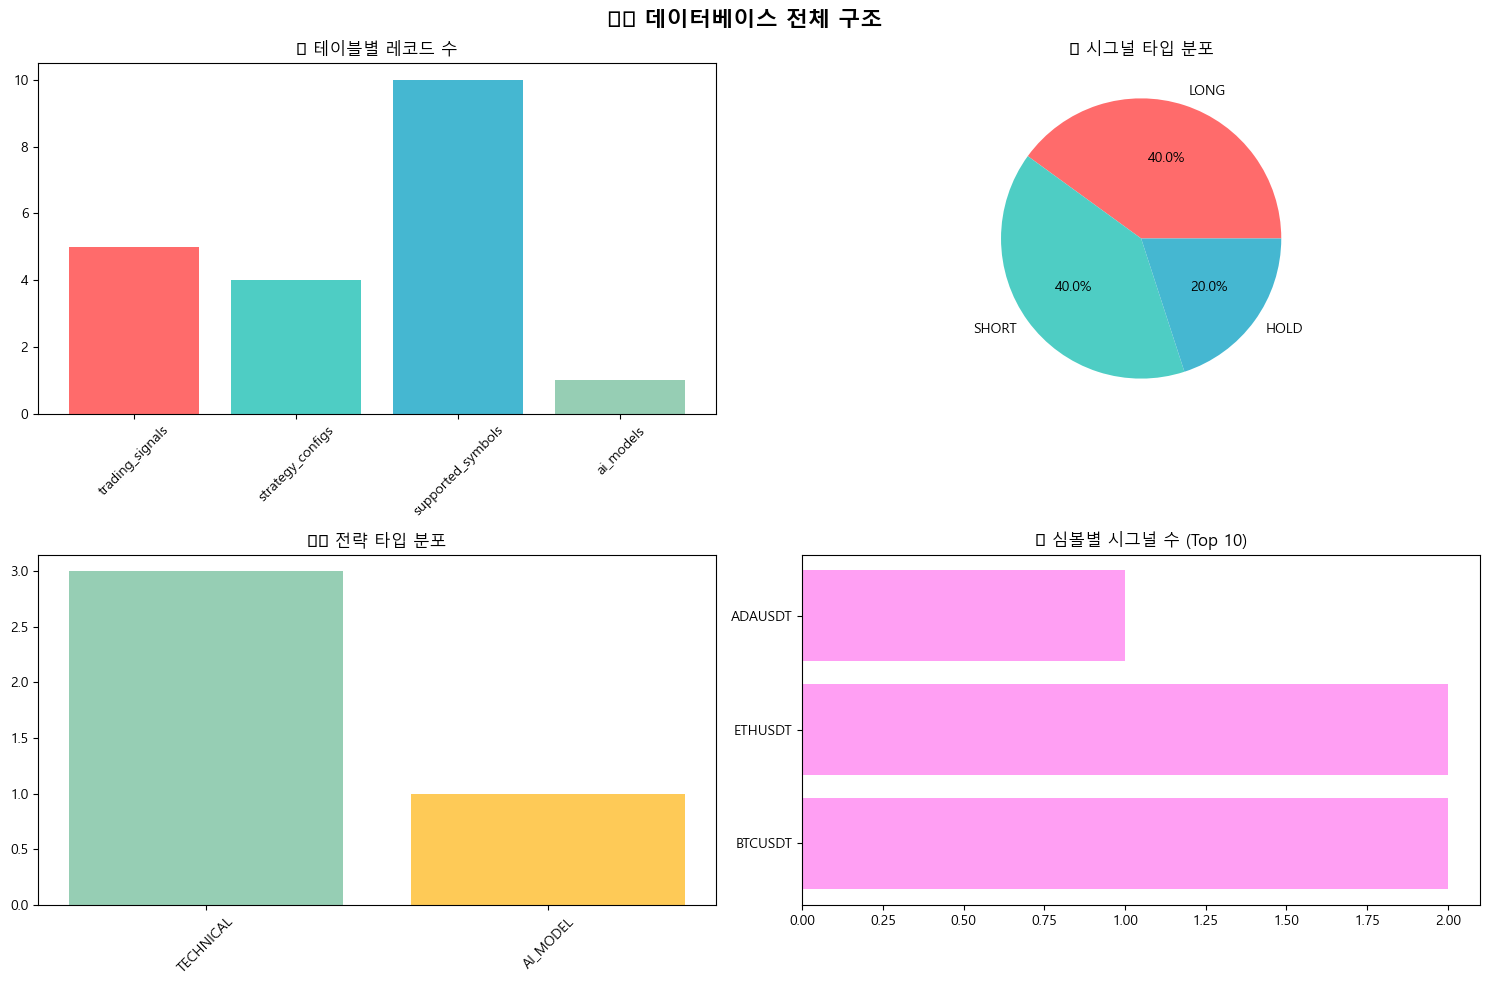

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [4]:
# SQL 데이터베이스 구조 시각화
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# DB 연결
DB_CONFIG = {
    'host': 'localhost',
    'port': 3306,
    'user': 'root',
    'password': 'ghkd2759A!',
    'database': 'trading_signals'
}

connection = mysql.connector.connect(**DB_CONFIG)

# 데이터 로드
signals_df = pd.read_sql("SELECT * FROM trading_signals", connection)
strategies_df = pd.read_sql("SELECT * FROM strategy_configs", connection)
symbols_df = pd.read_sql("SELECT * FROM supported_symbols", connection)
models_df = pd.read_sql("SELECT * FROM ai_models", connection)

print("🎨 데이터베이스 시각화 시작!")
print(f"📊 데이터 현황:")
print(f"  - 시그널: {len(signals_df)}개")
print(f"  - 전략: {len(strategies_df)}개") 
print(f"  - 심볼: {len(symbols_df)}개")
print(f"  - 모델: {len(models_df)}개")

# 1. 테이블 크기 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('🏗️ 데이터베이스 전체 구조', fontsize=16, fontweight='bold')

# 테이블 크기 비교
table_sizes = {
    'trading_signals': len(signals_df),
    'strategy_configs': len(strategies_df), 
    'supported_symbols': len(symbols_df),
    'ai_models': len(models_df)
}

axes[0,0].bar(table_sizes.keys(), table_sizes.values(), 
              color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
axes[0,0].set_title('📊 테이블별 레코드 수')
axes[0,0].tick_params(axis='x', rotation=45)

# 시그널 타입 분포
if len(signals_df) > 0:
    signal_counts = signals_df['signal_type'].value_counts()
    axes[0,1].pie(signal_counts.values, labels=signal_counts.index, autopct='%1.1f%%',
                  colors=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    axes[0,1].set_title('📶 시그널 타입 분포')
else:
    axes[0,1].text(0.5, 0.5, '데이터 없음', ha='center', va='center')
    axes[0,1].set_title('📶 시그널 타입 분포')

# 전략 타입 분포
if len(strategies_df) > 0:
    strategy_counts = strategies_df['strategy_type'].value_counts()
    axes[1,0].bar(strategy_counts.index, strategy_counts.values,
                  color=['#96CEB4', '#FECA57'])
    axes[1,0].set_title('⚙️ 전략 타입 분포')
    axes[1,0].tick_params(axis='x', rotation=45)

# 심볼 분포 (상위 10개)
if len(signals_df) > 0:
    symbol_counts = signals_df['symbol'].value_counts().head(10)
    axes[1,1].barh(symbol_counts.index, symbol_counts.values, color='#FF9FF3')
    axes[1,1].set_title('💰 심볼별 시그널 수 (Top 10)')
else:
    axes[1,1].text(0.5, 0.5, '데이터 없음', ha='center', va='center')
    axes[1,1].set_title('💰 심볼별 시그널 수')

plt.tight_layout()
plt.show()

# 2. Interactive Plotly 시각화
if len(signals_df) > 0:
    # 시간별 시그널 분포
    signals_df['created_at'] = pd.to_datetime(signals_df['created_at'])
    signals_df['date'] = signals_df['created_at'].dt.date
    
    daily_signals = signals_df.groupby(['date', 'signal_type']).size().reset_index(name='count')
    
    fig = px.bar(daily_signals, x='date', y='count', color='signal_type',
                 title='📈 일별 시그널 생성 현황',
                 labels={'date': '날짜', 'count': '시그널 수', 'signal_type': '시그널 타입'})
    fig.show()
    
    # 전략별 성능 (신뢰도)
    if 'confidence' in signals_df.columns:
        strategy_performance = signals_df.groupby('strategy_name')['confidence'].agg(['mean', 'count']).reset_index()
        
        fig = px.scatter(strategy_performance, x='count', y='mean', 
                        hover_name='strategy_name',
                        title='🎯 전략별 성능 (신뢰도 vs 시그널 수)',
                        labels={'count': '시그널 수', 'mean': '평균 신뢰도'})
        fig.show()

# 3. 데이터베이스 스키마 다이어그램 (텍스트)
print("\n🏗️ 데이터베이스 스키마:")
print("=" * 60)
print("""
trading_signals (메인 테이블)
├── id (PK)
├── strategy_name → strategy_configs.strategy_name
├── symbol → supported_symbols.symbol  
├── signal_type (LONG/SHORT/HOLD)
├── signal_source (TRADINGVIEW/AI_MODEL/BACKTEST)
├── price, confidence, created_at...

strategy_configs (전략 관리)
├── strategy_name (PK)
├── strategy_type (TECHNICAL/AI_MODEL/HYBRID)
├── parameters (JSON)
├── is_active

supported_symbols (심볼 관리)  
├── symbol (PK)
├── base_asset, quote_asset
├── is_active

ai_models (AI 모델 관리)
├── model_name (PK)
├── model_type, version
├── performance_metrics (JSON)
""")

# 4. 테이블 상세 정보
print("\n📋 테이블 상세 정보:")
print("=" * 60)

tables = {
    'trading_signals': signals_df,
    'strategy_configs': strategies_df, 
    'supported_symbols': symbols_df,
    'ai_models': models_df
}

for table_name, df in tables.items():
    print(f"\n🔍 {table_name}:")
    print(f"  📏 크기: {df.shape}")
    print(f"  📋 컬럼: {list(df.columns)}")
    if len(df) > 0:
        print(f"  📄 샘플:")
        print(df.head(2).to_string(index=False))
    print("-" * 40)

connection.close()

# 5. 관계형 데이터 조인 시각화
connection = mysql.connector.connect(**DB_CONFIG)

join_query = """
SELECT 
    ts.strategy_name,
    sc.strategy_type,
    ts.symbol,
    ss.base_asset,
    ts.signal_type,
    ts.confidence,
    ts.created_at
FROM trading_signals ts
LEFT JOIN strategy_configs sc ON ts.strategy_name = sc.strategy_name  
LEFT JOIN supported_symbols ss ON ts.symbol = ss.symbol
ORDER BY ts.created_at DESC
"""

joined_df = pd.read_sql(join_query, connection)
connection.close()

print(f"\n🔗 조인된 데이터 ({len(joined_df)}개 레코드):")
print(joined_df.head())

# Heatmap으로 전략-심볼 매트릭스
if len(joined_df) > 0:
    strategy_symbol_matrix = joined_df.groupby(['strategy_name', 'symbol']).size().unstack(fill_value=0)
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(strategy_symbol_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('🔥 전략-심볼 시그널 히트맵')
    plt.xlabel('심볼')
    plt.ylabel('전략')
    plt.tight_layout()
    plt.show()

print("\n🎉 시각화 완료! 데이터베이스 구조를 한눈에 파악할 수 있습니다.")